## Inference

In [1]:
from datasets import load_dataset, Audio
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from peft import LoraConfig, get_peft_model
sampling_rate = 16000 # 这个数据集本来就是16000
ds = load_dataset("MLCommons/ml_spoken_words", languages=["zh-CN"])
ds = ds.remove_columns(["file", 'is_valid',"language", "speaker_id", 'gender']) # 已检查，全部valid

/remote-home/pjli/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset ml_spoken_words (/remote-home/pjli/.cache/huggingface/datasets/MLCommons___ml_spoken_words/zh-CN_wav-6e7818d76df98faf/1.0.0/321ea853cf0a05abb7a2d7efea900692a3d8622af65a2f3ce98adb7800a5d57b)
100%|██████████| 3/3 [00:00<00:00, 508.46it/s]


In [2]:
train_set = ds['train']
val_set = ds['validation']
test_set = ds['test']

In [3]:
print(train_set)
print(val_set)
print(test_set)

Dataset({
    features: ['keyword', 'audio'],
    num_rows: 7647
})
Dataset({
    features: ['keyword', 'audio'],
    num_rows: 1234
})
Dataset({
    features: ['keyword', 'audio'],
    num_rows: 1232
})


In [4]:
# 检查数据集合法性
worddict = {}
for item in train_set:
    worddict[item['keyword']] = 1
for item in val_set:
    assert worddict[item['keyword']] == 1
for item in test_set:
    assert worddict[item['keyword']] == 1

In [5]:
labels = []
for item in worddict:
    labels.append(item)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(label2id)
print(id2label)
num_labels = len(id2label)

{'一些': 0, '三十四': 1, '三尖杉': 2, '三峡': 3, '三年': 4, '三维': 5, '上述': 6, '下表': 7, '不丹': 8, '不明': 9, '世代': 10, '世宗': 11, '东京': 12, '东侧': 13, '东南': 14, '东正教': 15, '东部': 16, '严谨': 17, '中举': 18, '为期': 19, '为首': 20, '主任委员': 21, '主体': 22, '主办': 23, '主线': 24, '主题曲': 25, '之中': 26, '乌头属': 27, '乔治亚州': 28, '乘客': 29, '九龙': 30, '争议': 31, '事务所': 32, '二十一': 33, '二氧化碳': 34, '于是': 35, '交会': 36, '交界': 37, '产于': 38, '人类': 39, '人类学': 40, '介面': 41, '任意': 42, '任职': 43, '众多': 44, '优良': 45, '传奇': 46, '传记': 47, '伴随': 48, '例如': 49, '供应': 50, '俄国': 51, '保加利亚': 52, '信用': 53, '俱乐部': 54, '偏好': 55, '停止': 56, '元素': 57, '光滑': 58, '兖州': 59, '入口': 60, '入境': 61, '入球': 62, '全市': 63, '八旗': 64, '公元': 65, '公司': 66, '公学': 67, '公家': 68, '兰德': 69, '关押': 70, '其实': 71, '具有': 72, '内尔': 73, '内战': 74, '内蒙古': 75, '军政': 76, '农业部': 77, '农场': 78, '凯尔': 79, '出使': 80, '出没': 81, '击败': 82, '分别': 83, '分子': 84, '分开': 85, '刑事': 86, '列表': 87, '初中': 88, '删除': 89, '剧场': 90, '副作用': 91, '努力': 92, '北海道': 93, '医师': 94, '十五': 95, '十八年': 96, '十字': 97, '十字花科':

In [48]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593",max_length = 100)
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=num_labels, label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True, max_length = 100
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- audio_spectrogram_transformer.embeddings.position_embeddings: found shape torch.Size([1, 1214, 768]) in the checkpoint and torch.Size([1, 110, 768]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([498, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([498]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-speech-commands-v2")
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-speech-commands-v2", num_labels=num_labels, label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
)


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-speech-commands-v2 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([35, 768]) in the checkpoint and torch.Size([498, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([498]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

In [10]:
train_set[0]["audio"]["array"].shape
# print(type(train_set[0]["audio"]["array"]))

(16000,)

In [11]:

inputs = feature_extractor(train_set[67]["audio"]["array"], sampling_rate =sampling_rate,return_tensors="pt")
input_values = inputs.input_values # [实际上input的字典也只有这一个属性]
print(input_values.shape)

torch.Size([1, 128, 128])


In [59]:
import torch
spectrogram = input_values.squeeze(0)
print(spectrogram.shape)
print(torch.max(spectrogram),torch.min(spectrogram),torch.mean(spectrogram))
# 假设你的频谱图存储在变量spectrogram中
spectrogram = input_values.squeeze(0)
spectrogram = spectrogram.permute(1,0)
print(spectrogram)

torch.Size([100, 128])
tensor(0.8887) tensor(-1.2776) tensor(-0.8611)
tensor([[-1.2776, -1.2776, -1.2776,  ..., -1.2776,  0.4670,  0.4670],
        [-1.2776, -1.2776, -1.2776,  ..., -1.2776,  0.4670,  0.4670],
        [-1.2776, -1.2776, -1.2776,  ..., -1.2776,  0.4670,  0.4670],
        ...,
        [-1.2776, -1.2776, -1.2776,  ..., -1.2776,  0.4670,  0.4670],
        [-1.2776, -1.2776, -1.2776,  ..., -1.2776,  0.4670,  0.4670],
        [-1.2776, -1.2776, -1.2776,  ..., -1.2776,  0.4670,  0.4670]])


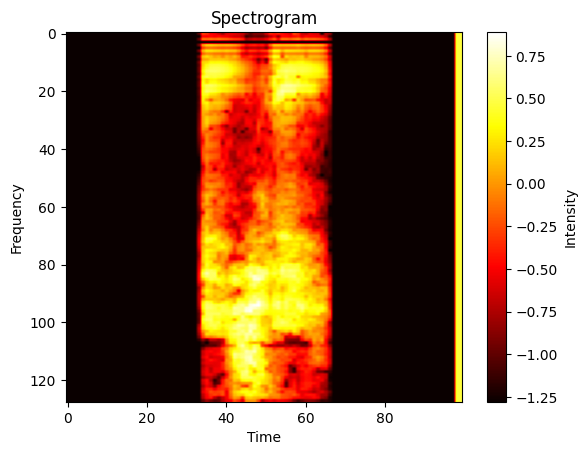

In [60]:
import matplotlib.pyplot as plt
import numpy as np



# 可视化频谱图
plt.imshow(spectrogram, cmap='hot', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Intensity')
plt.title('Spectrogram')
plt.show()


In [52]:
print(input_values.shape)

torch.Size([1, 100, 128])


In [53]:
outputs = model(input_values)

In [54]:
predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx], predicted_class_idx)
print('label:',train_set[0]['keyword'], label2id[train_set[0]['keyword']])

Predicted class: 原文 108
label: 一些 0


## Training

In [43]:
import torch
def mlc_collate_fn(data):
    batch = {}
    # batch['keyword'] = [d['keyword'] for d in data]
    batch['labels'] = torch.tensor([label2id[d['keyword']] for d in data])
    batch['input_values'] = torch.cat(
            [feature_extractor(d['audio']['array'], sampling_rate=sampling_rate, return_tensors="pt").input_values for d in data]) # a tensor of arrays return batch
    return batch
     

In [44]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True, collate_fn = mlc_collate_fn)

In [45]:
batch = next(iter(train_loader))

In [46]:
array = batch['input_values']
print(array.shape)
labels = batch['labels']
print(labels)

torch.Size([32, 1024, 128])
tensor([479, 162,  43, 258, 115, 357,  66,  31, 430,  31, 488, 123, 426, 184,
         66,  87, 261, 306,  39,   0, 115, 129, 184, 486, 120, 455,  16, 230,
        120,  98, 265, 173])


In [50]:
input = batch
output = model(**input)
print(output.logits)
print(output.loss)

tensor([[-0.1275,  0.2037, -0.0891,  ..., -0.8319, -0.5429, -1.6935],
        [-0.1864,  0.2159,  0.0325,  ..., -0.7147, -0.4246, -1.6985],
        [-0.0336,  0.1926,  0.1207,  ..., -0.8965, -0.3419, -1.5673],
        ...,
        [-0.4406,  0.3843,  0.0049,  ..., -0.8033, -0.1394, -1.3154],
        [-0.7949, -0.2037,  0.2747,  ..., -0.7223, -0.7143, -0.9888],
        [-0.1228, -0.1541, -0.2277,  ..., -0.9361, -0.4778, -1.8212]],
       grad_fn=<AddmmBackward0>)
tensor(6.3836, grad_fn=<NllLossBackward0>)


In [57]:
pred = output.logits.argmax(-1)
print(pred)
print(pred.shape[0])
labels = input['labels']
print(labels)
print(torch.sum(pred == labels)/pred.shape[0])

tensor([407, 407, 407, 407, 407, 276, 434, 407, 222, 434, 434, 454, 407, 132,
        434, 127, 127, 407, 165, 407, 407, 407, 407, 407, 407, 407,  60, 471,
        127, 407, 215, 407])
32
tensor([479, 162,  43, 258, 115, 357,  66,  31, 430,  31, 488, 123, 426, 184,
         66,  87, 261, 306,  39,   0, 115, 129, 184, 486, 120, 455,  16, 230,
        120,  98, 265, 173])
tensor(0.)
